<html lang="en"><head><style id="cssProviderStyle" type="text/css">div[data-form-block-id] .dialogProviderMessageContainerStyle { color: #A80000; padding-top: 20px; padding-bottom: 20px; text-align: center; }
                div[data-form-block-id] #validation-summary p[role=alert] { color: red; }
                div[data-form-block-id] .dialogProviderInternalContainerStyle { padding: 20px; position: absolute; }
                div[data-form-block-id] .dialogProviderIconContainerStyle { display: block; margin-left: auto; margin-right: auto; }
                div[data-form-block-id] .dialogProviderLinkContainerStyle { text-align: center; display: flex; align-items: center; justify-content: center; } 
                div[data-form-block-id] .dialogProviderContainerStyle { background: white; position: relative; }
                div[data-form-block-id] .dialogProviderLinkButtonContainerStyle { margin-top: 16px; text-align: center; display: flex; align-items: center; justify-content: cente
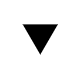

In [3]:
import requests
import json
import pandas as pd



#Startdatum + Enddatum definieren: Enddatum = heute, Startdatum = heute-30 Tage
startdatum = '2023-05-01'
enddatum = '2023-05-08'

#Daten aus Open-Meteo (Temperatur, Luftfeuchtigkeit etc.)
response = requests.get('https://api.open-meteo.com/v1/forecast?latitude=47.37&longitude=8.54&hourly=temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation_probability,precipitation,rain,showers,snowfall,snow_depth,weathercode,pressure_msl,surface_pressure,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,visibility,evapotranspiration,et0_fao_evapotranspiration,vapor_pressure_deficit,windspeed_10m,windspeed_80m,windspeed_120m,windspeed_180m,winddirection_10m,winddirection_80m,winddirection_120m,winddirection_180m,windgusts_10m,temperature_80m,temperature_120m,temperature_180m,soil_temperature_0cm,soil_temperature_6cm,soil_temperature_18cm,soil_temperature_54cm,soil_moisture_0_1cm,soil_moisture_1_3cm,soil_moisture_3_9cm,soil_moisture_9_27cm,soil_moisture_27_81cm,uv_index,uv_index_clear_sky,is_day,cape,freezinglevel_height,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,terrestrial_radiation,shortwave_radiation_instant,direct_radiation_instant,diffuse_radiation_instant,direct_normal_irradiance_instant,terrestrial_radiation_instant,temperature_1000hPa,temperature_975hPa,temperature_950hPa,temperature_925hPa,temperature_900hPa,temperature_850hPa,temperature_800hPa,temperature_700hPa,temperature_600hPa,temperature_500hPa,temperature_400hPa,temperature_300hPa,temperature_250hPa,temperature_200hPa,temperature_150hPa,temperature_100hPa,temperature_70hPa,temperature_50hPa,temperature_30hPa,relativehumidity_1000hPa,relativehumidity_975hPa,relativehumidity_950hPa,relativehumidity_925hPa,relativehumidity_900hPa,relativehumidity_850hPa,relativehumidity_800hPa,relativehumidity_700hPa,relativehumidity_600hPa,relativehumidity_500hPa,relativehumidity_400hPa,relativehumidity_300hPa,relativehumidity_250hPa,relativehumidity_200hPa,relativehumidity_150hPa,relativehumidity_100hPa,relativehumidity_70hPa,relativehumidity_50hPa,relativehumidity_30hPa,cloudcover_1000hPa,cloudcover_975hPa,cloudcover_950hPa,cloudcover_925hPa,cloudcover_900hPa,cloudcover_850hPa,cloudcover_800hPa,cloudcover_700hPa,cloudcover_600hPa,cloudcover_500hPa,cloudcover_400hPa,cloudcover_300hPa,cloudcover_250hPa,cloudcover_200hPa,cloudcover_150hPa,cloudcover_100hPa,cloudcover_70hPa,cloudcover_50hPa,cloudcover_30hPa,windspeed_1000hPa,windspeed_975hPa,windspeed_950hPa,windspeed_925hPa,windspeed_900hPa,windspeed_850hPa,windspeed_800hPa,windspeed_700hPa,windspeed_600hPa,windspeed_500hPa,windspeed_400hPa,windspeed_300hPa,windspeed_250hPa,windspeed_200hPa,windspeed_150hPa,windspeed_100hPa,windspeed_70hPa,windspeed_50hPa,windspeed_30hPa,winddirection_1000hPa,winddirection_975hPa,winddirection_950hPa,winddirection_925hPa,winddirection_900hPa,winddirection_850hPa,winddirection_800hPa,winddirection_700hPa,winddirection_600hPa,winddirection_500hPa,winddirection_400hPa,winddirection_300hPa,winddirection_250hPa,winddirection_200hPa,winddirection_150hPa,winddirection_100hPa,winddirection_70hPa,winddirection_50hPa,winddirection_30hPa&models=best_match,ecmwf_ifs04,metno_nordic,gfs_seamless,jma_seamless,icon_seamless,gem_seamless,meteofrance_seamless&daily=weathercode,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,sunrise,sunset,uv_index_max,uv_index_clear_sky_max,precipitation_sum,rain_sum,showers_sum,snowfall_sum,precipitation_hours,precipitation_probability_max,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration&start_date=' + startdatum + '&end_date=' + enddatum + '&timezone=Europe%2FBerlin')
weather_data = json.loads(response.content)
daily_data = weather_data['daily']

# DataFrame erstellen:
weather_df = pd.DataFrame(daily_data)

# Datum als Idex
weather_df.set_index('time', inplace=True)

weather_df.to_csv('Ausgabe.csv', index=False)

#--------------------------------------------------------------------------

#Daten aus Air Quality Index laden: Dynamische Website -> Laden mittels Silenium:
#ACHTUNG: Es öffnet sich ein separater Chrome-Browser zum AirQuality Index.
from bs4 import BeautifulSoup
from selenium import webdriver 
from selenium.webdriver.chrome.service import Service as ChromeService 
from webdriver_manager.chrome import ChromeDriverManager 

URL = "https://www.iqair.com/switzerland/zurich#highcharts-xb76aj7-136"
driver = webdriver.Chrome(service=ChromeService(
    ChromeDriverManager().install()))

driver.get(URL)

print(driver.page_source)


# Ausgabe df 
#print(weather_df)

##123